# 02 — Reward Shaping Diagnostics

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SharathSPhD/RLpower/blob/main/notebooks/02_reward_shaping.ipynb)

Inspect reward components (`r_tracking`, `r_efficiency`, `r_smoothness`) under randomized actions using `MockFMU`.

This notebook runs fully on Google Colab — no FMU binary is required. `MockFMU` provides physics-approximating state transitions sufficient for reward signal diagnostics.

In [1]:
%matplotlib inline
# ── Environment Setup (runs on Colab or locally) ──────────────────────────────
import subprocess, sys, os

IN_COLAB = "google.colab" in sys.modules
try:
    import google.colab  # noqa: F401
    IN_COLAB = True
except ImportError:
    pass

REPO_URL = "https://github.com/SharathSPhD/RLpower.git"
REPO_DIR = "/content/RLpower" if IN_COLAB else os.environ.get("WORKSPACE_DIR", "/workspace")

if IN_COLAB:
    if not os.path.exists(REPO_DIR):
        subprocess.run(["git", "clone", "--depth=1", REPO_URL, REPO_DIR], check=True)
    os.chdir(REPO_DIR)
    sys.path.insert(0, os.path.join(REPO_DIR, "src"))
    subprocess.run(
        [sys.executable, "-m", "pip", "install", "-q",
         "gymnasium>=0.29", "stable-baselines3>=2.3",
         "matplotlib", "numpy", "pyyaml", "scipy"],
        check=True,
    )
else:
    _src = os.path.join(REPO_DIR, "src")
    if _src not in sys.path:
        sys.path.insert(0, _src)
    os.chdir(REPO_DIR)

import matplotlib

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import yaml

from sco2rl.environment.sco2_env import SCO2FMUEnv
from sco2rl.simulation.fmu.mock_fmu import MockFMU

print(f"Environment: {'Google Colab' if IN_COLAB else 'Local/Docker'}")
print("Imports OK")

Environment: Local/Docker
Imports OK


In [2]:
ROOT = Path('.').resolve()
env_cfg = yaml.safe_load((ROOT / 'configs/environment/env.yaml').read_text())

obs_entries = [v for v in env_cfg['observation']['variables'] if v.get('fmu_var') is not None]
act_entries = env_cfg['action']['variables']

obs_vars = [v['fmu_var'] for v in obs_entries]
action_vars = [v['fmu_var'] for v in act_entries]
obs_bounds = {v['fmu_var']: (float(v['min']), float(v['max'])) for v in obs_entries}
action_cfg = {
    v['fmu_var']: {
        'min': float(v['physical_min']),
        'max': float(v['physical_max']),
        'rate': float(v.get('rate_limit_per_step', 0.05)),
    }
    for v in act_entries
}

design_point = {v['fmu_var']: 0.5 * (float(v['min']) + float(v['max'])) for v in obs_entries}

mock = MockFMU(
    obs_vars=obs_vars,
    action_vars=action_vars,
    design_point=design_point,
    seed=42,
)

cfg = {
    'obs_vars': obs_vars,
    'obs_bounds': obs_bounds,
    'action_vars': action_vars,
    'action_config': action_cfg,
    'history_steps': int(env_cfg['observation'].get('history_steps', 5)),
    'step_size': 5.0,
    'episode_max_steps': 240,
    'reward': env_cfg['reward'],
    'safety': {
        'T_compressor_inlet_min': -999.0,
        'surge_margin_min': -999.0,
    },
    'setpoint': {'W_net': 10.0},
}

env = SCO2FMUEnv(mock, cfg)
_ = env.reset(seed=7)

Collected 200 steps
mean r_tracking:  0.9775
mean r_efficiency:0.1275
mean reward_total:1.1045
Figure saved to /tmp/reward_shaping.png


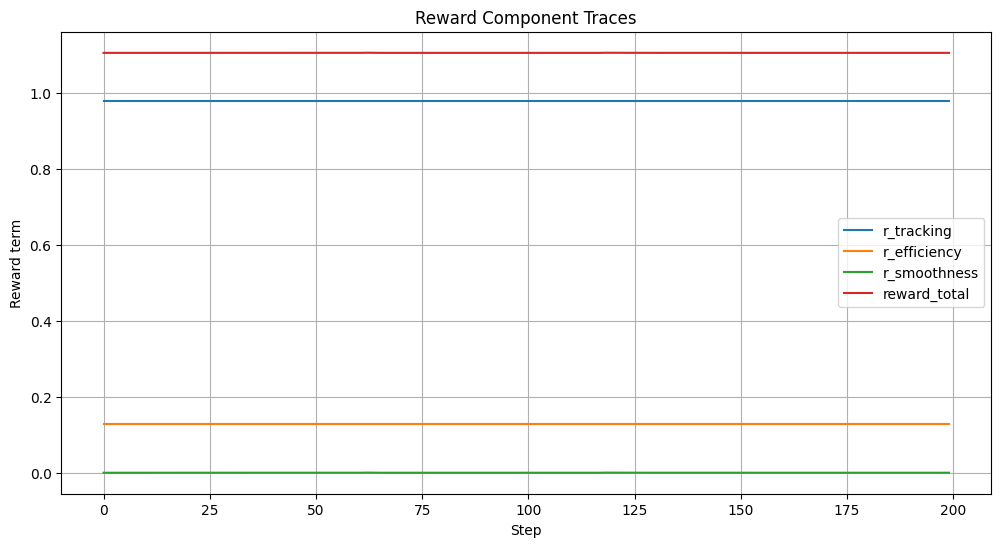

In [3]:
rng = np.random.default_rng(7)
steps = 200
series = {
    'r_tracking': [],
    'r_efficiency': [],
    'r_smoothness': [],
    'reward_total': [],
}

for _ in range(steps):
    action = rng.uniform(-1.0, 1.0, size=len(action_vars)).astype(np.float32)
    _, reward, terminated, truncated, info = env.step(action)
    rc = info['reward_components']
    series['r_tracking'].append(rc['r_tracking'])
    series['r_efficiency'].append(rc['r_efficiency'])
    series['r_smoothness'].append(rc['r_smoothness'])
    series['reward_total'].append(reward)
    if terminated or truncated:
        env.reset(seed=7)

env.close()

print(f"Collected {steps} steps")
print(f"mean r_tracking:  {np.mean(series['r_tracking']):.4f}")
print(f"mean r_efficiency:{np.mean(series['r_efficiency']):.4f}")
print(f"mean reward_total:{np.mean(series['reward_total']):.4f}")

fig, ax = plt.subplots(figsize=(12, 6))
for k, v in series.items():
    ax.plot(v, label=k)
ax.set_title('Reward Component Traces')
ax.set_xlabel('Step')
ax.set_ylabel('Reward term')
ax.grid(True)
ax.legend()
fig.savefig('/tmp/reward_shaping.png', dpi=72, bbox_inches='tight')
print("Figure saved to /tmp/reward_shaping.png")